# Análise Exploratória de Dados: Vendas Online

Este notebook realiza uma Análise Exploratória de Dados (EDA) em um conjunto de dados de vendas online. O objetivo é limpar e preparar os dados, entender suas principais características e extrair insights iniciais sobre clientes, produtos e padrões de vendas.

**Período Analisado:** Período dos dados válidos: de 01/12/2010 até 09/12/2011

**Ferramentas Utilizadas:** Python, Pandas, NumPy, Matplotlib, Seaborn.

## Limpeza e Preparação dos Dados

O processo inicial envolveu o carregamento e a limpeza dos dados para garantir a qualidade e a consistência para análises futuras:

- O dataset foi carregado do arquivo `data.csv` utilizando `pd.read_csv()`, sendo necessário especificar o encoding `latin1` para leitura correta.
- A inspeção inicial com `.shape` mostrou 541.909 linhas e 8 colunas.
- A verificação com `.isna().sum()` revelou uma quantidade significativa de valores ausentes (~25%) na coluna `CustomerID`. Para possibilitar análises focadas no cliente, as linhas com `CustomerID` nulo foram **removidas** usando `.dropna(subset=['CustomerID'])`, com isso, as linhas nulas em `Description` também foram **removidas** automáticamente. Isso resultou em um DataFrame com 406.829 linhas.
- A coluna `Quantity` e `CustomerID` foram convertidas para o tipo `int` após a remoção dos NaNs.
- A coluna `InvoiceDate` foi convertida do tipo `object` para `datetime` usando `pd.to_datetime()`, permitindo análises temporais.
- Foram extraídas colunas auxiliares `Ano`, `Mes`, `Dia`, `Hora` a partir da `InvoiceDate` para facilitar agrupamentos temporais.
- Foram identificadas linhas com `Quantity` negativa (provavelmente devoluções, muitas com `InvoiceNo` começando em 'C') e `UnitPrice` igual a zero. Para focar a análise em transações de vendas válidas, essas linhas foram **filtradas**, mantendo apenas `Quantity > 0` e `UnitPrice > 0`. O DataFrame resultante desta etapa foi chamado `df_vendas_validas`.
- Foi criada a coluna `ValorTotal` como o produto de `Quantity` e `UnitPrice`.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    df = pd.read_csv('data.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('data.csv', encoding='latin1')

print("--- Dimensões (df.shape) ---")
print(df.shape)

print("\n--- Primeiras 5 Linhas (df.head()) ---")
print(df.head())

print("\n--- Informações Gerais (df.info()) ---")
df.info()

print("\n--- Contagem de Dados Faltantes por Coluna (df.isna().sum()) ---")
print(df.isna().sum())

print("\n--- Estatísticas Descritivas (df.describe()) ---")
print(df.describe(include='all'))

--- Dimensões (df.shape) ---
(541909, 8)

--- Primeiras 5 Linhas (df.head()) ---
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

--- Informações Gerais (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (

In [56]:
percentual_nan_customer = (df['CustomerID'].isna().sum() / len(df)) * 100
print(f"Percentual de linhas com CustomerID faltando: {percentual_nan_customer:.1f}%")

df_limpo = df.dropna(subset=['CustomerID']).copy()

print(f"\nShape após remover linhas com CustomerID NaN: {df_limpo.shape}")

Percentual de linhas com CustomerID faltando: 24.9%

Shape após remover linhas com CustomerID NaN: (406829, 8)


In [57]:
df_limpo['Quantity'] = df_limpo['Quantity'].astype(int)
df_limpo['CustomerID'] = df_limpo['CustomerID'].astype(int)

df_limpo['InvoiceDate'] = pd.to_datetime(df_limpo['InvoiceDate'])
df_limpo['Ano'] = df_limpo['InvoiceDate'].dt.year
df_limpo['Mes'] = df_limpo['InvoiceDate'].dt.month
df_limpo['Dia'] = df_limpo['InvoiceDate'].dt.day
df_limpo['Hora'] = df_limpo['InvoiceDate'].dt.hour

print(df_limpo.info())

print("\nColunas de Ano, Mês, Dia, Hora extraídas:")
print(df_limpo[['InvoiceDate', 'Ano', 'Mes', 'Dia', 'Hora']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int32         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int32         
 7   Country      406829 non-null  object        
 8   Ano          406829 non-null  int32         
 9   Mes          406829 non-null  int32         
 10  Dia          406829 non-null  int32         
 11  Hora         406829 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(6), object(4)
memory usage: 31.0+ MB
None

Colunas de Ano, Mês, Dia, Hora extraídas:
          InvoiceDate   Ano  Mes  Dia  Hora
0 2010-12-01 08:26:0

In [58]:
print("\n--- Investigando Quantidade < 0 ---")
df_neg_qnt = df_limpo[df_limpo['Quantity'] < 0]

print(f"Número de linhas com Quantidade negativa: {len(df_neg_qnt)}")
if not df_neg_qnt.empty:
    print("\nExemplo de linhas com Quantidade negativa:")
    print(df_neg_qnt.head())
    print("\n--- InvoiceNo começa com 'C' nessas linhas? ---", df_neg_qnt['InvoiceNo'].str.startswith('C').all())
    print("UnitPrice > 0 nessas linhas? ", (df_neg_qnt['UnitPrice'] > 0).all())

print("\n--- Investigando UnitPrice == 0 ---")
df_zero_preco = df_limpo[df_limpo['UnitPrice'] == 0]
print(f"Número de linhas com UnitPrice zero: {len(df_zero_preco)}")
if not df_zero_preco.empty:
    print("\nExemplo de linhas com UnitPrice zero:")
    print(df_zero_preco.head(10)) 
    
    print("\n--- Clientes únicos com UnitPrice zero: ---\n", df_zero_preco['CustomerID'].unique())


--- Investigando Quantidade < 0 ---
Número de linhas com Quantidade negativa: 8905

Exemplo de linhas com Quantidade negativa:
    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country   Ano  Mes  \
141 2010-12-01 09:41:00      27.50       14527  United Kingdom  2010   12   
154 2010-12-01 09:49:00       4.65       15311  United Kingdom  2010   12   
235 2010-12-01 10:24:00       1.65       17548  United Kingdom  2010   12   
236 2010-12-01 10:24:00       0.29       17548  United Kingdom  2010   12   
237 2010-12-01 10:24:00       0.29       17548  United Kingd

In [59]:
print(f"Shape antes de filtrar vendas inválidas: {df_limpo.shape}")

df_vendas_validas = df_limpo[(df_limpo['Quantity'] > 0) & (df_limpo['UnitPrice'] > 0)].copy()
print(f"Shape após filtrar vendas inválidas: {df_vendas_validas.shape}")

print("\nMínimo de Quantity agora:", df_vendas_validas['Quantity'].min())
print("Mínimo de UnitPrice agora:", df_vendas_validas['UnitPrice'].min())

print("\n--- Primeiras linhas do df_vendas_validas: ---")
print(df_vendas_validas.head())

Shape antes de filtrar vendas inválidas: (406829, 12)
Shape após filtrar vendas inválidas: (397884, 12)

Mínimo de Quantity agora: 1
Mínimo de UnitPrice agora: 0.001

--- Primeiras linhas do df_vendas_validas: ---
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country   Ano  Mes  Dia  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  2010   12    1   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  2010   12    1   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  2010   12    1   
3 2010-12-01 08:26:00       3.39 

In [60]:
print("--- Calculando ValorTotal (Quantity * UnitPrice) ---")

df_vendas_validas['ValorTotal'] = df_vendas_validas['Quantity'] * df_vendas_validas['UnitPrice']
print("\nDataFrame com a nova coluna 'ValorTotal':")
print(df_vendas_validas[['Quantity', 'UnitPrice', 'ValorTotal']].head())

print("\nEstatísticas da coluna 'ValorTotal':")
print(df_vendas_validas['ValorTotal'].describe())

--- Calculando ValorTotal (Quantity * UnitPrice) ---

DataFrame com a nova coluna 'ValorTotal':
   Quantity  UnitPrice  ValorTotal
0         6       2.55       15.30
1         6       3.39       20.34
2         8       2.75       22.00
3         6       3.39       20.34
4         6       3.39       20.34

Estatísticas da coluna 'ValorTotal':
count    397884.000000
mean         22.397000
std         309.071041
min           0.001000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: ValorTotal, dtype: float64


## Principais Achados da Análise Exploratória

### Análise Geográfica (Vendas por País)

A análise do faturamento total (`ValorTotal`), calculado como `Quantity * UnitPrice` para vendas válidas, foi agrupada por país (`Country`) para identificar as principais origens geográficas da receita.

Foi utilizada a seguinte operação Pandas para obter a soma de `ValorTotal` por país, ordenando e selecionando os 10 maiores:

In [63]:
top_10_paises = df_vendas_validas.groupby('Country')['ValorTotal'].sum().sort_values(ascending=False).head(10)
print("--- Total Vendido por País ---")
top_10_paises = top_10_paises.reset_index()
print(top_10_paises)

--- Total Vendido por País ---
          Country   ValorTotal
0  United Kingdom  7308391.554
1     Netherlands   285446.340
2            EIRE   265545.900
3         Germany   228867.140
4          France   209024.050
5       Australia   138521.310
6           Spain    61577.110
7     Switzerland    56443.950
8         Belgium    41196.340
9          Sweden    38378.330


Para visualizar a diferença de magnitude entre os países, foi gerado um gráfico de barras dos Top 10:

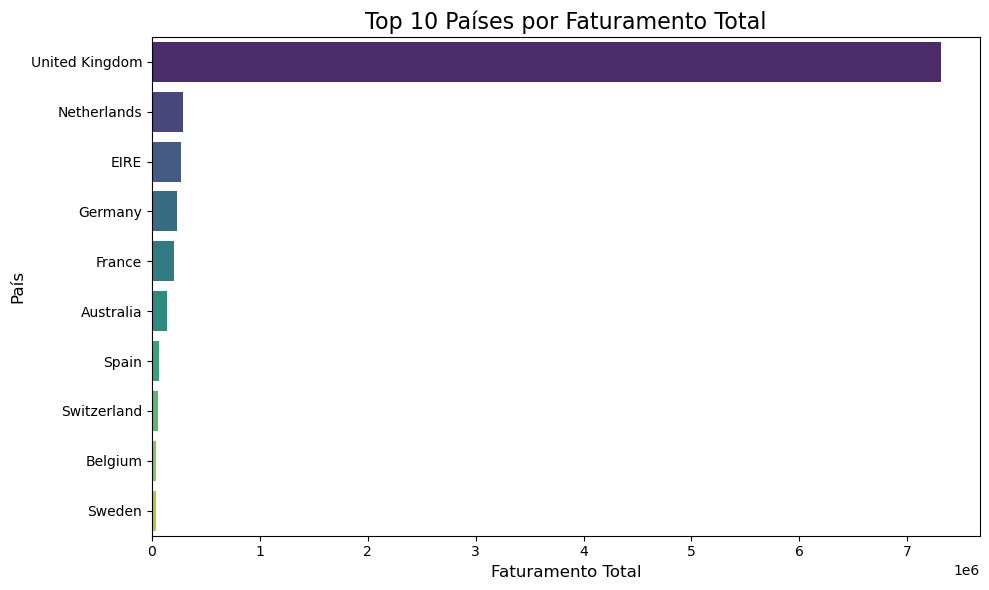

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_paises,
    x='ValorTotal',
    y='Country',
    hue='Country',
    palette='viridis',
    legend=False
)

plt.title('Top 10 Países por Faturamento Total', fontsize=16)
plt.xlabel('Faturamento Total', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.tight_layout()
plt.show()

**Conclusão (Países):** O resultado e o gráfico confirmam a **dominância expressiva do Reino Unido (United Kingdom)** no faturamento total. Os outros países no Top 10, como Netherlands, EIRE e Germany (ver gráfico/tabela), apresentam valores consideravelmente menores, indicando uma forte concentração geográfica das vendas neste dataset.

### Análise de Produtos (Mais Vendidos por Quantidade)

Para identificar os produtos mais populares, foi analisada a quantidade total vendida (`Quantity`) agrupada pela descrição do produto (`Description`). Os 10 produtos com maior quantidade total vendida foram selecionados:

In [68]:
df_top10_product = df_vendas_validas.groupby('Description')['ValorTotal'].sum().sort_values(ascending=False).head(10).reset_index()

A visualização em gráfico de barras ajuda a comparar a popularidade dos produtos em termos de volume:

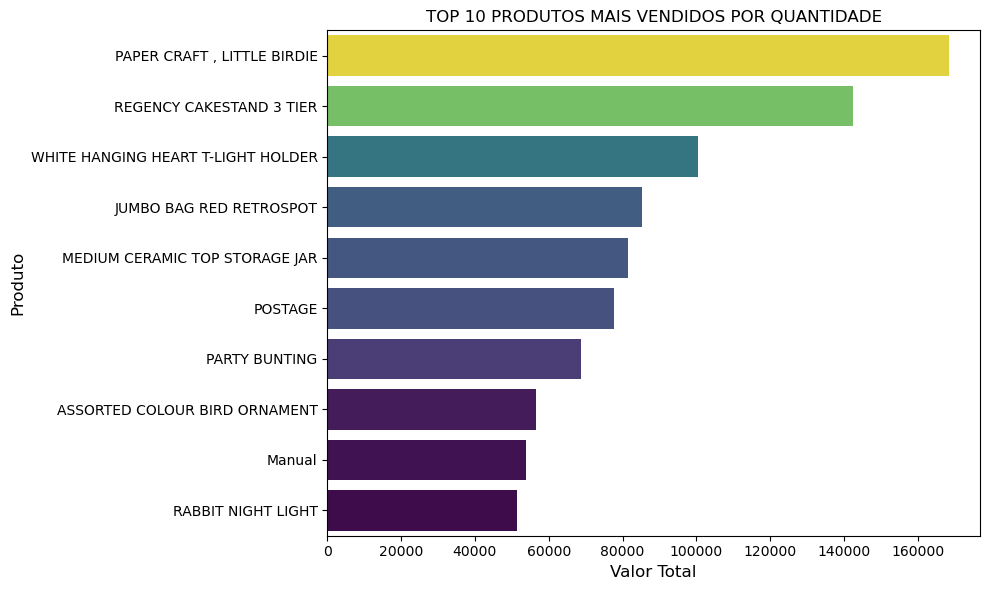

In [70]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_top10_product,
    x='ValorTotal',
    y='Description',
    palette='viridis',
    hue='ValorTotal',
    legend=False
)
plt.title('TOP 10 PRODUTOS MAIS VENDIDOS POR QUANTIDADE')
plt.xlabel('Valor Total', fontsize=12)
plt.ylabel('Produto', fontsize=12)
plt.tight_layout()
plt.show()

**Conclusão (Produtos):** Observa-se que o produto "PAPER CRAFT , LITTLE BIRDIE" é, de longe, o item com maior quantidade vendida. Outros produtos populares incluem "REGENCY CAKESTAND 3 TIER" e "WHITE HANGING HEART T-LIGHT HOLDER". Isso pode indicar produtos chave para o negócio ou itens de baixo valor vendidos em grande volume.

### Análise de Clientes (Top Clientes por Valor Gasto)

Identificar os clientes que mais contribuem para o faturamento é crucial para estratégias de negócio e marketing. Para isso, agrupamos os dados de vendas válidas (`df_vendas_validas`) por `CustomerID` e somamos o `ValorTotal` gasto por cada cliente. Os resultados foram ordenados para destacar os clientes mais valiosos.

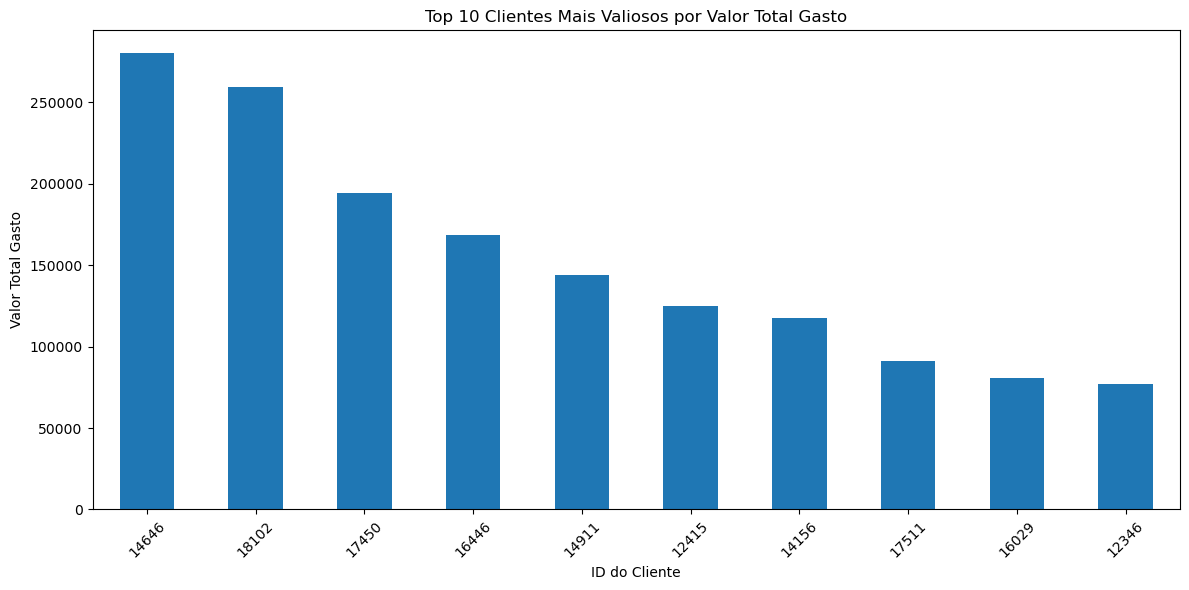

CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
12415    124914.53
14156    117379.63
17511     91062.38
16029     81024.84
12346     77183.60
Name: ValorTotal, dtype: float64

In [73]:
df_top10_customer = df_vendas_validas.groupby('CustomerID')['ValorTotal'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
df_top10_customer.plot(kind='bar')
plt.title('Top 10 Clientes Mais Valiosos por Valor Total Gasto')
plt.xlabel('ID do Cliente')
plt.ylabel('Valor Total Gasto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_top10_customer

### Análise Temporal (Vendas Mensais)

Para entender a evolução das vendas ao longo do tempo, a coluna `InvoiceDate` foi convertida para o formato datetime e as colunas `Ano` e `Mes` foram extraídas. Em seguida, o `ValorTotal` foi agrupado por Ano e Mês para calcular o faturamento mensal.

In [75]:
df_sazonais = df_vendas_validas.groupby(['Ano','Mes'])['ValorTotal'].sum()
df_sazonais

Ano   Mes
2010  12      572713.890
2011  1       569445.040
      2       447137.350
      3       595500.760
      4       469200.361
      5       678594.560
      6       661213.690
      7       600091.011
      8       645343.900
      9       952838.382
      10     1039318.790
      11     1161817.380
      12      518192.790
Name: ValorTotal, dtype: float64

O resultado agregado mensalmente foi visualizado em um gráfico de linhas para identificar tendências ou sazonalidades:

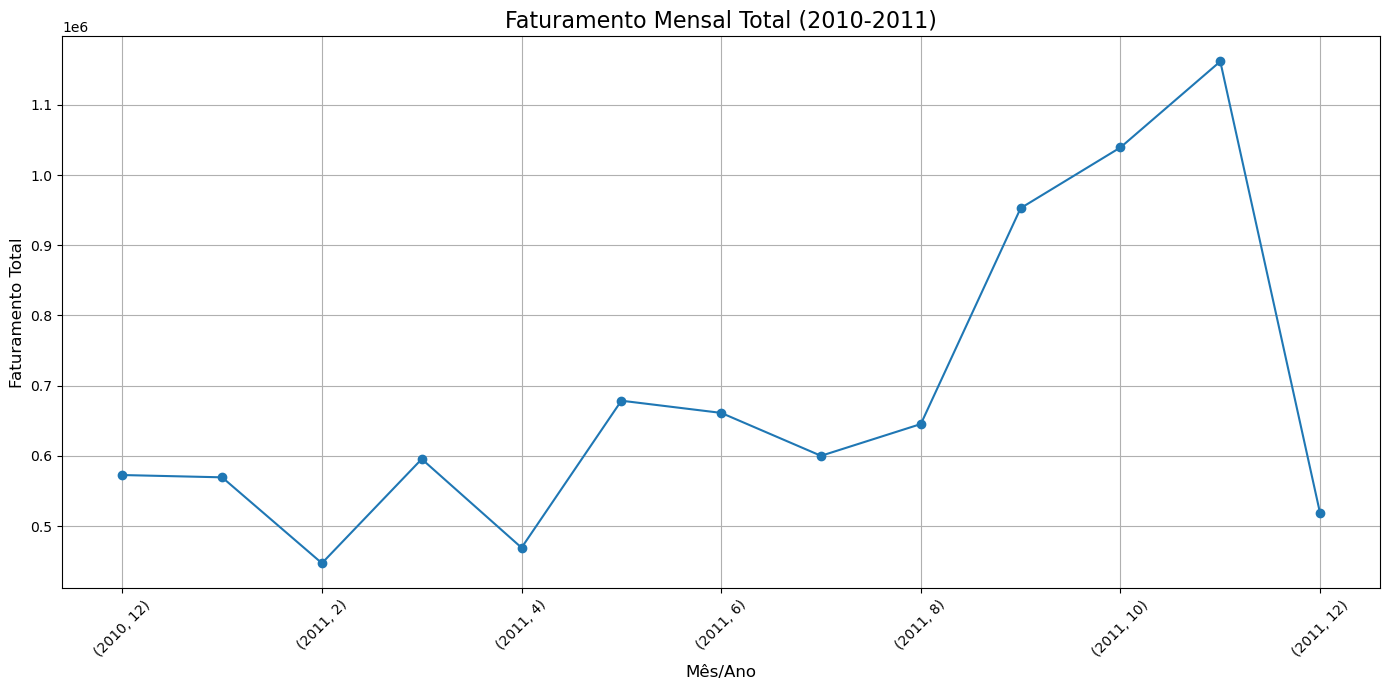

In [77]:
plt.figure(figsize=(14, 7))
df_sazonais.plot(kind='line', marker='o', linestyle='-')

plt.title('Faturamento Mensal Total (2010-2011)', fontsize=16)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Faturamento Total', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Conclusão (Temporal):** O gráfico de linha mostra a evolução do faturamento mensal durante o período coberto pelos dados. Observa-se um pico significativo de vendas nos meses de Outubro e Novembro de 2011. No entanto, como o dataset cobre essencialmente apenas um ano completo (Dez/2010 a Dez/2011), **não é possível confirmar se este pico é um padrão sazonal recorrente** (pré-Natal, por exemplo) ou um evento específico daquele ano. Seriam necessários dados de anos adicionais para confirmar a sazonalidade.

### Análise de Preços (Distribuição do UnitPrice)

Para entender melhor a política de preços ou o tipo de produto comercializado, analisamos a distribuição dos preços unitários (`UnitPrice`) das vendas válidas. Utilizamos estatísticas descritivas e um histograma.

count    397884.000000
mean          3.116488
std          22.097877
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

Gerando histograma para preços abaixo de 20...


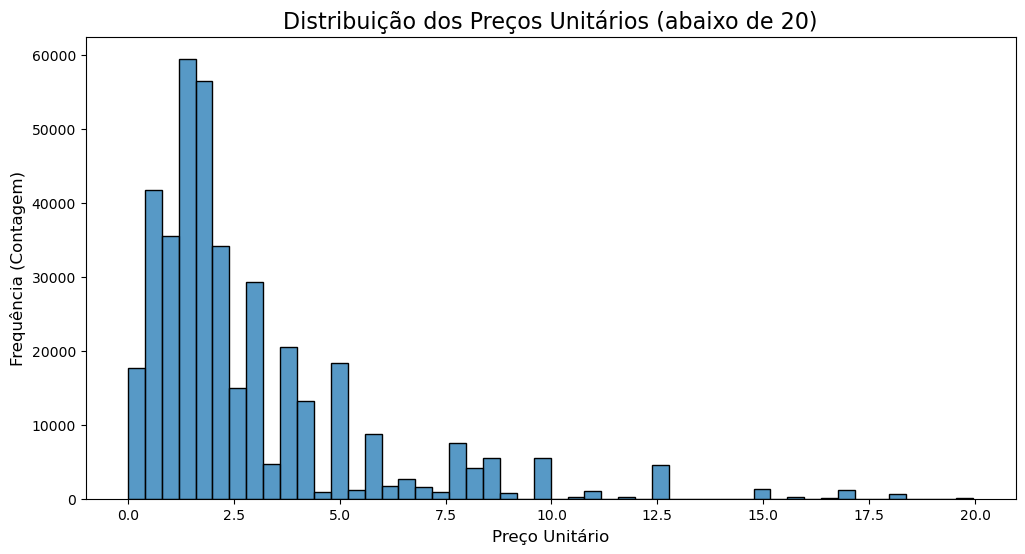

In [80]:
print(df_vendas_validas['UnitPrice'].describe())

limite_preco_viz = 20
df_preco_filtrado_viz = df_vendas_validas[df_vendas_validas['UnitPrice'] < limite_preco_viz]

print(f"\nGerando histograma para preços abaixo de {limite_preco_viz}...")

plt.figure(figsize=(12, 6))
sns.histplot(data=df_preco_filtrado_viz, x='UnitPrice', bins=50)
plt.title(f'Distribuição dos Preços Unitários (abaixo de {limite_preco_viz})', fontsize=16)
plt.xlabel('Preço Unitário', fontsize=12)
plt.ylabel('Frequência (Contagem)', fontsize=12)
plt.show()

**Conclusão (Preços):** A análise descritiva (`describe()`) e o histograma confirmam que **a grande maioria dos produtos possui um preço unitário baixo**, com uma forte concentração de valores abaixo de 10. Apesar disso, a presença de um valor máximo de 8142.75 e a longa cauda no histograma (mesmo filtrado) indicam a existência de **outliers com preços significativamente altos**. Essa distribuição assimétrica (enviesada à direita) sugere uma variedade grande no catálogo de produtos, desde itens muito baratos até alguns bem caros, ou a possibilidade de erros/itens especiais que mereceriam investigação adicional em um contexto real.

## Conclusão Geral da Análise Exploratória (EDA)

Esta Análise Exploratória de Dados inicial no dataset de vendas online permitiu obter uma compreensão valiosa sobre os dados e o negócio subjacente:

1.  **Estrutura e Qualidade:** O dataset, após carregamento e inspeção, revelou a necessidade de limpeza, principalmente relacionada a um alto volume de `CustomerID`s ausentes (~25%) e à presença de transações indicativas de devoluções (`Quantity` < 0) ou com preço zero/inválido. O tratamento dessas questões (remoção de linhas sem `CustomerID`, filtro de vendas inválidas, conversão de tipos de dados como `InvoiceDate`) foi crucial para preparar um conjunto de dados mais confiável (`df_vendas_validas`) para análise.

2.  **Visão de Negócio:** As agregações e visualizações forneceram insights chave:
    * **Geografia:** Forte concentração de vendas no **Reino Unido**.
    * **Produtos:** Identificação clara dos produtos mais vendidos em volume (liderados por "PAPER CRAFT , LITTLE BIRDIE").
    * **Clientes:** Identificação dos clientes de maior valor (liderados pelo ID 14646), sugerindo potencial para ações de fidelização.
    * **Tempo:** Observação de um **pico de vendas no final de 2011** (Out/Nov), indicando possível sazonalidade pré-natal, embora a confirmação exija dados de mais anos.
    * **Preços:** Confirmação de um catálogo com predominância de itens de **baixo valor**, mas com existência de produtos de alto valor (outliers).

3.  **Próximos Passos Possíveis:** Esta EDA abre caminho para análises mais profundas, como:
    * Segmentação de Clientes (ex: RFM - Recência, Frequência, Valor Monetário).
    * Análise de Cesta de Compras (Market Basket Analysis).
    * Investigação mais detalhada sobre devoluções e produtos com preço zero.
    * Criação de modelos de previsão de vendas (requereria mais dados históricos).

Em suma, a análise exploratória foi essencial para limpar, entender e extrair os primeiros padrões e insights valiosos deste conjunto de dados.